<a href="https://colab.research.google.com/github/moeinset/few_shot_learning/blob/main/Copy_of_few_shot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import needed libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
import torchvision

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average


In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "few_shot_data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # # Download data
    # with open(data_path / "few_shot_data.zip", "wb") as f:
    #     request = requests.get("url")
    #     print("Downloading ...")
    #     f.write(request.content)

    # Unzip data
    with zipfile.ZipFile(data_path / "few_shot_data.zip", "r") as zip_ref:
        print("Unzipping data...") 
        zip_ref.extractall(image_path)

data/few_shot_data directory exists.


In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data/few_shot_data'.
There are 0 directories and 0 images in 'data/few_shot_data/.ipynb_checkpoints'.
There are 4 directories and 0 images in 'data/few_shot_data/test'.
There are 0 directories and 15 images in 'data/few_shot_data/test/1'.
There are 0 directories and 15 images in 'data/few_shot_data/test/4'.
There are 0 directories and 15 images in 'data/few_shot_data/test/3'.
There are 0 directories and 15 images in 'data/few_shot_data/test/2'.
There are 4 directories and 0 images in 'data/few_shot_data/train'.
There are 0 directories and 25 images in 'data/few_shot_data/train/1'.
There are 0 directories and 25 images in 'data/few_shot_data/train/4'.
There are 0 directories and 25 images in 'data/few_shot_data/train/3'.
There are 0 directories and 25 images in 'data/few_shot_data/train/2'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/few_shot_data/train'), PosixPath('data/few_shot_data/test'))

Random image path: data/few_shot_data/train/1/BGRA2HLS.closemeshwork2.jpg
Image class: 1
Image height: 768
Image width: 1024


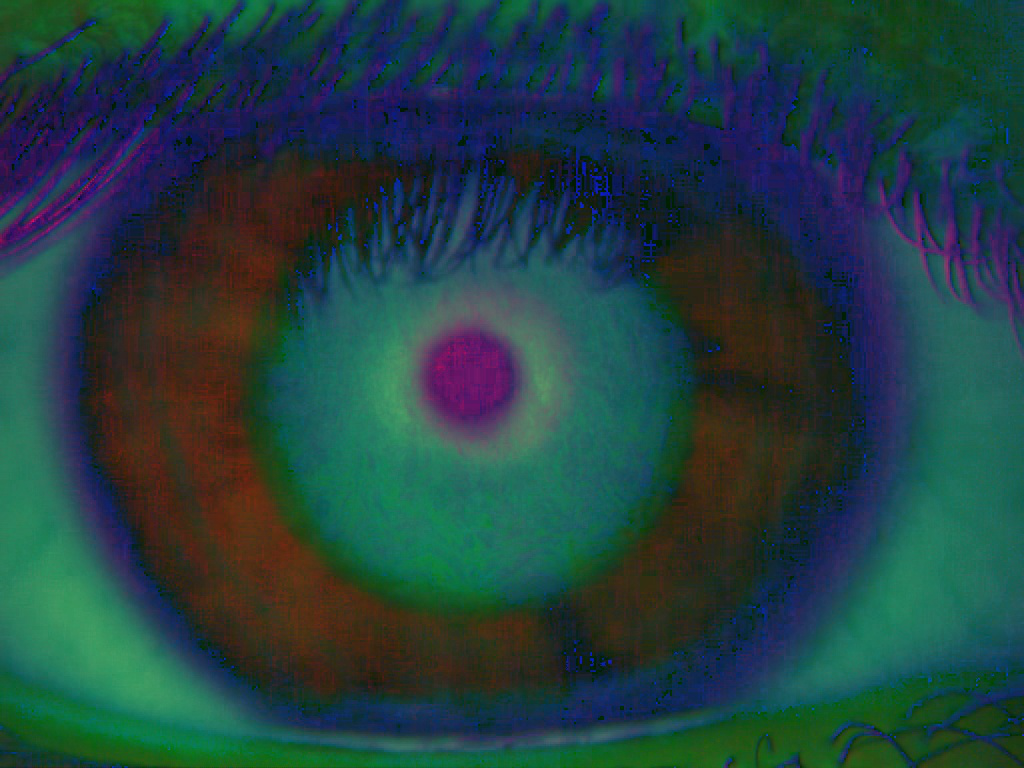

In [8]:
import random
from PIL import Image

# Set seed
#random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img
     

In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet18_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()


In [ ]:
# image_size = 28

# # NB: background=True selects the train set, background=False selects the test set
# # It's the nomenclature from the original paper, we just have to deal with it

# train_set = Omniglot(
#     root="./data",
#     background=True,
#     transform=transforms.Compose(
#         [
#             transforms.Grayscale(num_output_channels=3),
#             transforms.RandomResizedCrop(image_size),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#         ]
#     ),
#     download=True,
# )
# test_set = Omniglot(
#     root="./data",
#     background=False,
#     transform=transforms.Compose(
#         [
#             # Omniglot images have 1 channel, but our model will expect 3-channel images
#             transforms.Grayscale(num_output_channels=3),
#             transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
#             transforms.CenterCrop(image_size),
#             transforms.ToTensor(),
#         ]
#     ),
#     download=True,
# )


In [10]:
# Turn image folders into Datasets
train_data = datasets.ImageFolder(train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(test_dir, transform=auto_transforms)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 100
     Root location: data/few_shot_data/train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ), Dataset ImageFolder
     Number of datapoints: 60
     Root location: data/few_shot_data/test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ))

In [11]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

In [12]:
#get pretrained model weights and import them to model
weights = torchvision.models.ResNet18_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.resnet18(weights = weights)

In [13]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [14]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 
     

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [15]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = model
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 4  # Number of images per class in the support set
N_QUERY = 3  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_data.get_labels = lambda: [
    instance[1] for instance in test_data.
]
test_sampler = TaskSampler(
    test_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_data,
    batch_sampler=test_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)




In [26]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


ValueError: ignored

In [22]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )


NameError: ignored

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

In [ ]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


In [ ]:
# Or just load mine

!wget https://public-sicara.s3.eu-central-1.amazonaws.com/easy-fsl/resnet18_with_pretraining.tar
model.load_state_dict(torch.load("resnet18_with_pretraining.tar", map_location="cuda"))


In [ ]:
evaluate(test_loader)
